## Importing Required Libraries

In [1]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-learn Utilities
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Advanced Techniques
from imblearn.over_sampling import SMOTENC
from xgboost import XGBRegressor
import optuna

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


C:\ProgramData\anaconda3\envs\MS_Dissertation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preparation

In [2]:
# Load the data
data_path = 'Data/'
appearances = pd.read_csv(data_path + 'appearances.csv')
games = pd.read_csv(data_path + 'games.csv')
players = pd.read_csv(data_path + 'players.csv')
player_stats = pd.read_csv(data_path + 'Player_Stats_Data.csv', encoding='utf-8')
player_valuation = pd.read_csv(data_path + 'player_valuations.csv')


In [3]:
appearances.head()

appearance_id  game_id  player_id  player_club_id  player_current_club_id  \
0   2231978_38004  2231978      38004             853                     235   
1   2233748_79232  2233748      79232            8841                    2698   
2   2234413_42792  2234413      42792            6251                     465   
3   2234418_73333  2234418      73333            1274                    6646   
4  2234421_122011  2234421     122011             195                    3008   

         date       player_name competition_id  yellow_cards  red_cards  \
0  2012-07-03  Aurélien Joachim            CLQ             0          0   
1  2012-07-05    Ruslan Abyshov            ELQ             0          0   
2  2012-07-05       Sander Puri            ELQ             0          0   
3  2012-07-05   Vegar Hedenstad            ELQ             0          0   
4  2012-07-05  Markus Henriksen            ELQ             0          0   

   goals  assists  minutes_played  
0      2        0              90  
1      0        0              90  
2      0        0              45  
3      0        0              90  
4      0        1              90

In [4]:
games.head()

game_id competition_id  season         round        date  home_club_id  \
0  2321044             L1    2013   2. Matchday  2013-08-18            16   
1  2321060             L1    2013   3. Matchday  2013-08-25            23   
2  2321086             L1    2013   6. Matchday  2013-09-21             4   
3  2321152             L1    2013  11. Matchday  2013-11-02            44   
4  2321205             L1    2013  17. Matchday  2013-12-21            41   

   away_club_id  home_club_goals  away_club_goals  home_club_position  ...  \
0            23                2                1                 1.0  ...   
1            24                0                2                18.0  ...   
2            16                1                1                15.0  ...   
3            33                0                2                 7.0  ...   
4            39                2                3                14.0  ...   

                 stadium attendance          referee  \
0      SIGNAL IDUNA PARK    80200.0     Peter Sippel   
1      EINTRACHT-Stadion    23325.0   Wolfgang Stark   
2    Max-Morlock-Stadion    50000.0     Knut Kircher   
3  Olympiastadion Berlin    69277.0      Günter Perl   
4       Volksparkstadion    50000.0  Bastian Dankert   

                                                 url  home_club_formation  \
0  https://www.transfermarkt.co.uk/borussia-dortm...              4-2-3-1   
1  https://www.transfermarkt.co.uk/eintracht-brau...              4-3-2-1   
2  https://www.transfermarkt.co.uk/1-fc-nuremberg...              4-2-3-1   
3  https://www.transfermarkt.co.uk/hertha-bsc_fc-...              4-2-3-1   
4  https://www.transfermarkt.co.uk/hamburger-sv_1...              4-2-3-1   

  away_club_formation          home_club_name  \
0             4-3-2-1       Borussia Dortmund   
1             4-2-3-1  Eintracht Braunschweig   
2             4-2-3-1          1.FC Nuremberg   
3             4-2-3-1              Hertha BSC   
4       4-4-2 Diamond            Hamburger SV   

                         away_club_name aggregate competition_type  
0                Eintracht Braunschweig       2:1  domestic_league  
1        Eintracht Frankfurt Fußball AG       0:2  domestic_league  
2                     Borussia Dortmund       1:1  domestic_league  
3                         FC Schalke 04       0:2  domestic_league  
4  1. Fußball- und Sportverein Mainz 05       2:3  domestic_league  

[5 rows x 23 columns]

In [5]:
players.head()

player_id first_name     last_name                name  last_season  \
0         10   Miroslav         Klose      Miroslav Klose         2015   
1         26      Roman  Weidenfeller  Roman Weidenfeller         2017   
2         65    Dimitar      Berbatov    Dimitar Berbatov         2015   
3         77        NaN         Lúcio               Lúcio         2012   
4         80        Tom        Starke          Tom Starke         2017   

   current_club_id         player_code    country_of_birth city_of_birth  \
0              398      miroslav-klose              Poland         Opole   
1               16  roman-weidenfeller             Germany          Diez   
2             1091    dimitar-berbatov            Bulgaria   Blagoevgrad   
3              506               lucio              Brazil      Brasília   
4               27          tom-starke  East Germany (GDR)       Freital   

  country_of_citizenship  ...   foot height_in_cm contract_expiration_date  \
0                Germany  ...  right        184.0                      NaN   
1                Germany  ...   left        190.0                      NaN   
2               Bulgaria  ...    NaN          NaN                      NaN   
3                 Brazil  ...    NaN          NaN                      NaN   
4                Germany  ...  right        194.0                      NaN   

             agent_name                                          image_url  \
0  ASBW Sport Marketing  https://img.a.transfermarkt.technology/portrai...   
1      Neubauer 13 GmbH  https://img.a.transfermarkt.technology/portrai...   
2       CSKA-AS-23 Ltd.  https://img.a.transfermarkt.technology/portrai...   
3                   NaN  https://img.a.transfermarkt.technology/portrai...   
4                   IFM  https://img.a.transfermarkt.technology/portrai...   

                                                 url  \
0  https://www.transfermarkt.co.uk/miroslav-klose...   
1  https://www.transfermarkt.co.uk/roman-weidenfe...   
2  https://www.transfermarkt.co.uk/dimitar-berbat...   
3  https://www.transfermarkt.co.uk/lucio/profil/s...   
4  https://www.transfermarkt.co.uk/tom-starke/pro...   

  current_club_domestic_competition_id  \
0                                  IT1   
1                                   L1   
2                                  GR1   
3                                  IT1   
4                                   L1   

                                   current_club_name market_value_in_eur  \
0                      Società Sportiva Lazio S.p.A.           1000000.0   
1                                  Borussia Dortmund            750000.0   
2  Panthessalonikios Athlitikos Omilos Konstantin...           1000000.0   
3                             Juventus Football Club            200000.0   
4                                  FC Bayern München            100000.0   

  highest_market_value_in_eur  
0                  30000000.0  
1                   8000000.0  
2                  34500000.0  
3                  24500000.0  
4                   3000000.0  

[5 rows x 23 columns]

In [6]:
player_stats.head()

Season        Player  Position  Appearances  Wins  Losses  \
0  2024/25   Max Aarons   Defender            0     0       0   
1  2023/24   Max Aarons   Defender           20     4      12   
2  2022/23   Max Aarons   Defender            0     0       0   
3  2021/22   Max Aarons   Defender           34     4      24   
4  2020/21   Max Aarons   Defender            0     0       0   

   Last man tackles  Freekicks scored  Yellow cards  Fouls  ...  Punches  \
0               0.0               NaN             0      0  ...      NaN   
1               0.0               NaN             1     12  ...      NaN   
2               0.0               NaN             0      0  ...      NaN   
3               1.0               NaN             8     27  ...      NaN   
4               0.0               NaN             0      0  ...      NaN   

   Clearances  Errors leading to goal Duels lost  Aerial battles lost  \
0         0.0                     0.0        0.0                  0.0   
1        21.0                     0.0       57.0                 11.0   
2         0.0                     0.0        0.0                  0.0   
3        71.0                     0.0      151.0                 50.0   
4         0.0                     0.0        0.0                  0.0   

   Goals Conceded  Through balls  Saves  Headed goals  Red cards  
0             0.0            0.0    NaN           0.0          0  
1            34.0            2.0    NaN           0.0          0  
2             0.0            0.0    NaN           0.0          0  
3            69.0            5.0    NaN           0.0          0  
4             0.0            0.0    NaN           0.0          0  

[5 rows x 56 columns]

In [7]:
player_valuation.head()

player_id        date  market_value_in_eur  current_club_id  \
0     405973  2000-01-20               150000             3057   
1     342216  2001-07-20               100000             1241   
2       3132  2003-12-09               400000              126   
3       6893  2003-12-15               900000              984   
4         10  2004-10-04              7000000              398   

  player_club_domestic_competition_id  
0                                 BE1  
1                                 SC1  
2                                 TR1  
3                                 GB1  
4                                 IT1

In [8]:
# Merging Appearances with Games

appearances_merged = appearances[appearances['competition_id'] == 'GB1'].merge(
    games,
    how = 'inner',
    left_on=['game_id'],
    right_on=['game_id']
).groupby(['player_name','player_club_id','season']).size().reset_index(name="Count")

# Keep only rows with exactly one occurrence at ['player_id', 'season'] level
appearances_merged = appearances_merged[
    appearances_merged.groupby(['player_name', 'season'])['player_name'].transform('count') == 1
]


In [9]:
# Strip whitespace from player names in player_stats to avoid mismatches
player_stats['Player'] = player_stats['Player'].str.strip()

# Convert 'Tackle success %' column from percentage to numeric
player_stats['Tackle success %'] = player_stats['Tackle success %'].str.rstrip('%').astype('float') / 100

# Convert 'Cross accuracy %' column from percentage to numeric
player_stats['Cross accuracy %'] = player_stats['Cross accuracy %'].str.rstrip('%').astype('float') / 100

# Convert 'Shooting accuracy %' column from percentage to numeric
player_stats['Shooting accuracy %'] = player_stats['Shooting accuracy %'].str.rstrip('%').astype('float') / 100



In [10]:
player_stats['Season'] = player_stats['Season'].apply(lambda x : int(str(x).split("/")[0]))

player_stats_filtered = player_stats[player_stats['Appearances'] > 0]
player_valuation = player_valuation[(player_valuation['date'] <= '2024-08-31')]

In [11]:
# Function to determine the season based on the transfer_date
def get_season(transfer_date):
    date = pd.to_datetime(transfer_date)
    year = date.year
    if date >= pd.to_datetime(f"{year}-06-01") and date <= pd.to_datetime(f"{year + 1}-02-02"):
        return year - 1
    elif date < pd.to_datetime(f"{year}-06-01"):
        return year - 1
    else:
        return year

# Apply the function to create the season column
player_valuation['season'] = player_valuation['date'].apply(get_season)


player_valuation = player_valuation.groupby(
    ['player_id','season'], as_index = False
)['market_value_in_eur'].mean()


In [12]:
player_valuation[player_valuation['player_id'] == 134425]

player_id  season  market_value_in_eur
115954     134425    2011         2.500000e+06
115955     134425    2012         1.200000e+07
115956     134425    2013         1.650000e+07
115957     134425    2014         4.000000e+07
115958     134425    2015         4.666667e+07
115959     134425    2016         4.666667e+07
115960     134425    2017         9.666667e+07
115961     134425    2018         1.500000e+08
115962     134425    2019         1.220000e+08
115963     134425    2020         9.166667e+07
115964     134425    2021         7.000000e+07
115965     134425    2022         5.250000e+07
115966     134425    2023         3.500000e+07

In [13]:
df = player_valuation.merge(
    players,
    how = 'inner',
    left_on=['player_id'],
    right_on=['player_id']
)

In [14]:
df

player_id  season  market_value_in_eur_x first_name     last_name  \
0              10    2003              7000000.0   Miroslav         Klose   
1              10    2004             12000000.0   Miroslav         Klose   
2              10    2005             25000000.0   Miroslav         Klose   
3              10    2006             23000000.0   Miroslav         Klose   
4              10    2007             20000000.0   Miroslav         Klose   
...           ...     ...                    ...        ...           ...   
249561    1237998    2023               100000.0   Richmond        Gyamfi   
249562    1237999    2023               100000.0     Samuel       Obinaya   
249563    1240467    2023                50000.0      Artem  Prysyazhnyuk   
249564    1240762    2023                50000.0    Araphat      Mohammed   
249565    1247360    2023                50000.0       Ivan       M'Bahia   

                      name  last_season  current_club_id         player_code  \
0           Miroslav Klose         2015              398      miroslav-klose   
1           Miroslav Klose         2015              398      miroslav-klose   
2           Miroslav Klose         2015              398      miroslav-klose   
3           Miroslav Klose         2015              398      miroslav-klose   
4           Miroslav Klose         2015              398      miroslav-klose   
...                    ...          ...              ...                 ...   
249561     Richmond Gyamfi         2024              678     richmond-gyamfi   
249562      Samuel Obinaya         2023            55686      samuel-obinaya   
249563  Artem Prysyazhnyuk         2024             6992  artem-prysyazhnyuk   
249564    Araphat Mohammed         2024             2778    araphat-mohammed   
249565        Ivan M'Bahia         2023             3524         ivan-mbahia   

       country_of_birth  ...   foot height_in_cm contract_expiration_date  \
0                Poland  ...  right        184.0                      NaN   
1                Poland  ...  right        184.0                      NaN   
2                Poland  ...  right        184.0                      NaN   
3                Poland  ...  right        184.0                      NaN   
4                Poland  ...  right        184.0                      NaN   
...                 ...  ...    ...          ...                      ...   
249561              NaN  ...  right          NaN      2029-06-30 00:00:00   
249562          Ukraine  ...  right        184.0      2027-06-30 00:00:00   
249563          Ukraine  ...   left        180.0      2027-06-30 00:00:00   
249564              NaN  ...   left          NaN                      NaN   
249565    Cote d'Ivoire  ...  right        174.0      2028-06-30 00:00:00   

                  agent_name  \
0       ASBW Sport Marketing   
1       ASBW Sport Marketing   
2       ASBW Sport Marketing   
3       ASBW Sport Marketing   
4       ASBW Sport Marketing   
...                      ...   
249561  TJ Player Advice ApS   
249562                   NaN   
249563            Ivan Bobko   
249564                   NaN   
249565            BLACKSKILL   

                                                image_url  \
0       https://img.a.transfermarkt.technology/portrai...   
1       https://img.a.transfermarkt.technology/portrai...   
2       https://img.a.transfermarkt.technology/portrai...   
3       https://img.a.transfermarkt.technology/portrai...   
4       https://img.a.transfermarkt.technology/portrai...   
...                                                   ...   
249561  https://img.a.transfermarkt.technology/portrai...   
249562  https://img.a.transfermarkt.technology/portrai...   
249563  https://img.a.transfermarkt.technology/portrai...   
249564  https://img.a.transfermarkt.technology/portrai...   
249565  https://img.a.transfermarkt.technology/portrai...   

                                                      url  \
0       https://ww

In [15]:
player_stats_filtered_with_current_club = player_stats_filtered.merge(
    appearances_merged,
    how = 'inner',
    left_on = ['Player','Season'],
    right_on = ['player_name','season']
)

In [16]:
player_stats_filtered_with_current_club

Season           Player  Position  Appearances  Wins  Losses  \
0       2023       Max Aarons  Defender           20     4      12   
1       2021       Max Aarons  Defender           34     4      24   
2       2019       Max Aarons  Defender           36     4      26   
3       2023  Josh Acheampong  Defender            1     1       0   
4       2024   Adam Armstrong   Forward            5     0       4   
...      ...              ...       ...          ...   ...     ...   
6384    2016  Wayne Routledge       NaN           27     7      18   
6385    2015  Wayne Routledge       NaN           28    11      11   
6386    2014  Wayne Routledge       NaN           29    11      11   
6387    2013  Wayne Routledge       NaN           35    10      18   
6388    2012  Wayne Routledge       NaN           36    10      14   

      Last man tackles  Freekicks scored  Yellow cards  Fouls  ...  \
0                  0.0               NaN             1     12  ...   
1                  1.0               NaN             8     27  ...   
2                  0.0               NaN             7     29  ...   
3                  0.0               NaN             0      0  ...   
4                  NaN               0.0             1      1  ...   
...                ...               ...           ...    ...  ...   
6384               NaN               0.0             1     28  ...   
6385               NaN               0.0             3     30  ...   
6386               NaN               0.0             1     36  ...   
6387               NaN               0.0             2     34  ...   
6388               NaN               0.0             0     37  ...   

      Aerial battles lost  Goals Conceded  Through balls  Saves  Headed goals  \
0                    11.0            34.0            2.0    NaN           0.0   
1                    50.0            69.0            5.0    NaN           0.0   
2                    50.0            71.0            0.0    NaN           0.0   
3                     1.0             0.0            0.0    NaN           0.0   
4                     NaN             NaN            NaN    NaN           0.0   
...                   ...             ...            ...    ...           ...   
6384                 44.0             NaN            0.0    NaN           1.0   
6385                 34.0             NaN            3.0    NaN           0.0   
6386                 44.0             NaN            7.0    NaN           0.0   
6387                 41.0             NaN            5.0    NaN           0.0   
6388                 31.0             NaN            9.0    NaN           0.0   

      Red cards      player_name  player_club_id  season  Count  
0             0       Max Aarons             989    2023     20  
1             0       Max Aarons            1123    2021     34  
2             0       Max Aarons            1123    2019     36  
3             0  Josh Acheampong             631    2023      1  
4             0   Adam Armstrong             180    2024      5  
...         ...              ...             ...     ...    ...  
6384          0  Wayne Routledge            2288    2016     27  
6385          0  Wayne Routledge            2288    2015     28  
6386          1  Wayne Routledge            2288    2014     29  
6387          0  Wayne Routledge            2288    2013     35  
6388          0  Wayne Routledge            2288    2012     36  

[6389 rows x 60 columns]

In [17]:
final_df = player_stats_filtered_with_current_club.merge(
    df,
    how = 'inner',
    left_on=['Player','Season'],
    right_on=['name','season']
)

In [18]:
pd.set_option('display.max_columns', None)
final_df

Season           Player  Position  Appearances  Wins  Losses  \
0       2023       Max Aarons  Defender           20     4      12   
1       2021       Max Aarons  Defender           34     4      24   
2       2019       Max Aarons  Defender           36     4      26   
3       2023  Josh Acheampong  Defender            1     1       0   
4       2022   Adam Armstrong   Forward           30     6      18   
...      ...              ...       ...          ...   ...     ...   
6062    2016  Wayne Routledge       NaN           27     7      18   
6063    2015  Wayne Routledge       NaN           28    11      11   
6064    2014  Wayne Routledge       NaN           29    11      11   
6065    2013  Wayne Routledge       NaN           35    10      18   
6066    2012  Wayne Routledge       NaN           36    10      14   

      Last man tackles  Freekicks scored  Yellow cards  Fouls  \
0                  0.0               NaN             1     12   
1                  1.0               NaN             8     27   
2                  0.0               NaN             7     29   
3                  0.0               NaN             0      0   
4                  NaN               0.0             2     17   
...                ...               ...           ...    ...   
6062               NaN               0.0             1     28   
6063               NaN               0.0             3     30   
6064               NaN               0.0             1     36   
6065               NaN               0.0             2     34   
6066               NaN               0.0             0     37   

      Shots on target  Sweeper clearances  Assists  Tackle success %  \
0                 NaN                 NaN        1              0.66   
1                 NaN                 NaN        2              0.69   
2                 NaN                 NaN        1              0.63   
3                 NaN                 NaN        0              0.00   
4                12.0                 NaN        1               NaN   
...               ...                 ...      ...               ...   
6062              9.0                 NaN        1              0.68   
6063              9.0                 NaN        1              0.87   
6064              8.0                 NaN        1              0.81   
6065             11.0                 NaN        4              0.84   
6066             17.0                 NaN        4              0.74   

      Duels won  Goals with left foot  Accurate long balls  Shots  \
0          74.0                   0.0                 20.0    NaN   
1         163.0                   0.0                 36.0    NaN   
2         167.0                   0.0                 38.0    NaN   
3           0.0                   0.0                  0.0    NaN   
4           NaN                   2.0                  NaN   25.0   
...         ...                   ...                  ...    ...   
6062       72.0                   0.0                 22.0   19.0   
6063       67.0                   0.0                 21.0   18.0   
6064      113.0                   0.0                 25.0   31.0   
6065      117.0                   1.0                 49.0   27.0   
6066      112.0                   0.0                 54.0   30.0   

      Penalties Saved  Crosses  Goals with right foot  Shooting accuracy %  \
0                 NaN     13.0                    0.0                  NaN   
1                 NaN     50.0                    0.0                  NaN   
2                 NaN     73.0                    0.0                  NaN   
3                 NaN      0.0                    0.0                  NaN   
4                 NaN     14.0                    0.0                 0.48   
...               ...      ...                    ...                  ...   
6062              NaN     82.0                    2.0                 0.47   
6063              NaN     67.0                    2.0             

In [19]:
def calculate_age(date_of_birth, season):
    birth_year = pd.to_datetime(date_of_birth).year
    age = season - birth_year
    return age

# Apply the function to calculate age
final_df['age'] = final_df.apply(lambda row: calculate_age(row['date_of_birth'], row['Season']), axis=1)


In [20]:
final_df.shape

(6067, 86)

In [21]:
final_df.to_csv('Player_valuation_final.csv',index = False)

## Data Analysis

In [22]:
final_df = final_df[['Player','country_of_birth','city_of_birth','country_of_citizenship',
'sub_position','foot','Position','player_club_id','Season','Appearances','Wins',
'Losses','Last man tackles','Freekicks scored','Yellow cards','Fouls',
'Shots on target','Sweeper clearances','Assists','Tackle success %','Duels won',
'Goals with left foot','Accurate long balls','Shots','Penalties Saved','Crosses',
'Goals with right foot','Shooting accuracy %','Passes','Catches','Passes per match',
'Headed Clearance','Throw outs','Tackles','Big Chances Created','Hit woodwork',
'High Claims','Goals per match','Offsides','Goal Kicks','Big chances missed',
'Blocked shots','Penalties scored','Clean sheets','Own goals','Successful 50/50s',
'Recoveries','Clearances off line','Goals','Interceptions','Aerial battles won',
'Cross accuracy %','Punches','Clearances','Errors leading to goal',
'Duels lost','Aerial battles lost','Goals Conceded','Through balls','Saves',
'Headed goals','Red cards','height_in_cm','age','market_value_in_eur_x']]

### Number of Records

In [23]:
final_df.shape

(6067, 65)

### Dataset info

In [24]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6067 entries, 0 to 6066
Data columns (total 65 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Player                  6067 non-null   object 
 1   country_of_birth        5975 non-null   object 
 2   city_of_birth           6052 non-null   object 
 3   country_of_citizenship  5990 non-null   object 
 4   sub_position            6067 non-null   object 
 5   foot                    6014 non-null   object 
 6   Position                6015 non-null   object 
 7   player_club_id          6067 non-null   int64  
 8   Season                  6067 non-null   int64  
 9   Appearances             6067 non-null   int64  
 10  Wins                    6067 non-null   int64  
 11  Losses                  6067 non-null   int64  
 12  Last man tackles        2041 non-null   float64
 13  Freekicks scored        3560 non-null   float64
 14  Yellow cards            6067 non-null   

### Season Range for the dataset

In [25]:
print("Season Data is from :",final_df['Season'].min()," - ",final_df['Season'].max())

Season Data is from : 2012  -  2023


### Unique Players in the dataset

In [26]:
len(final_df['Player'].unique())

1929

###  Null Values

In [27]:
with pd.option_context('display.max_rows', None):
  display(final_df.isnull().sum().sort_values(ascending=False))

Throw outs                5601
Saves                     5601
Catches                   5601
High Claims               5601
Sweeper clearances        5601
Goal Kicks                5601
Penalties Saved           5601
Punches                   5601
Last man tackles          4026
Clearances off line       4026
Clean sheets              3560
Own goals                 3560
Goals Conceded            3560
Shots                     2507
Freekicks scored          2507
Goals per match           2507
Shots on target           2507
Big chances missed        2507
Penalties scored          2507
Shooting accuracy %       2507
Successful 50/50s         1915
Recoveries                1915
Cross accuracy %          1915
Aerial battles won        1915
Aerial battles lost       1915
Tackle success %          1915
Through balls             1915
Duels won                 1915
Duels lost                1915
Accurate long balls       1449
Errors leading to goal    1449
Clearances                 466
Offsides

### Plots for Analysis

In [28]:
# Set the style for plots
sns.set(style="whitegrid")
palette = sns.color_palette('husl', len(final_df['Position'].unique()))

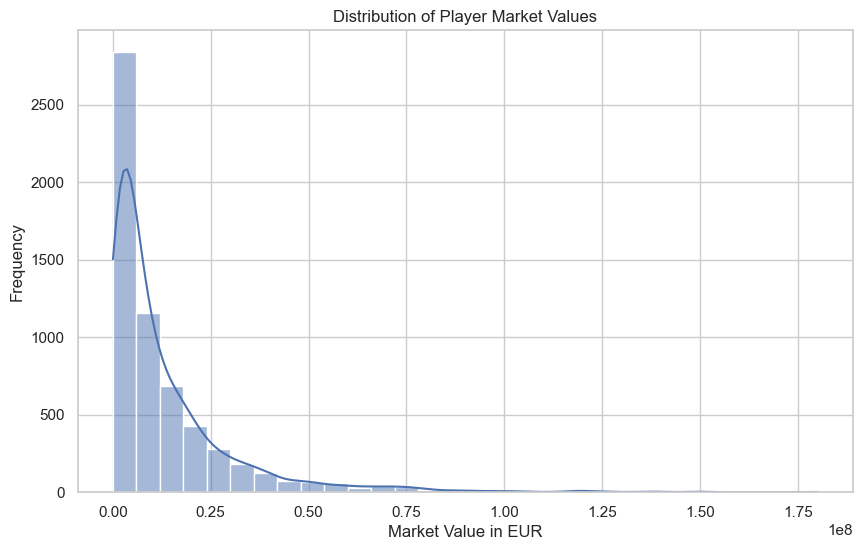

In [29]:
# 1. Distribution of Player Market Values (No specific position filter needed)
plt.figure(figsize=(10, 6))
sns.histplot(final_df['market_value_in_eur_x'].dropna(), kde=True, bins=30)
plt.xlabel('Market Value in EUR')
plt.ylabel('Frequency')
plt.title('Distribution of Player Market Values')
plt.show()


C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3355414897.py:3: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(x='Position', y='market_value_in_eur_x', data=final_df, palette=palette, hue = 'Position', legend = False)


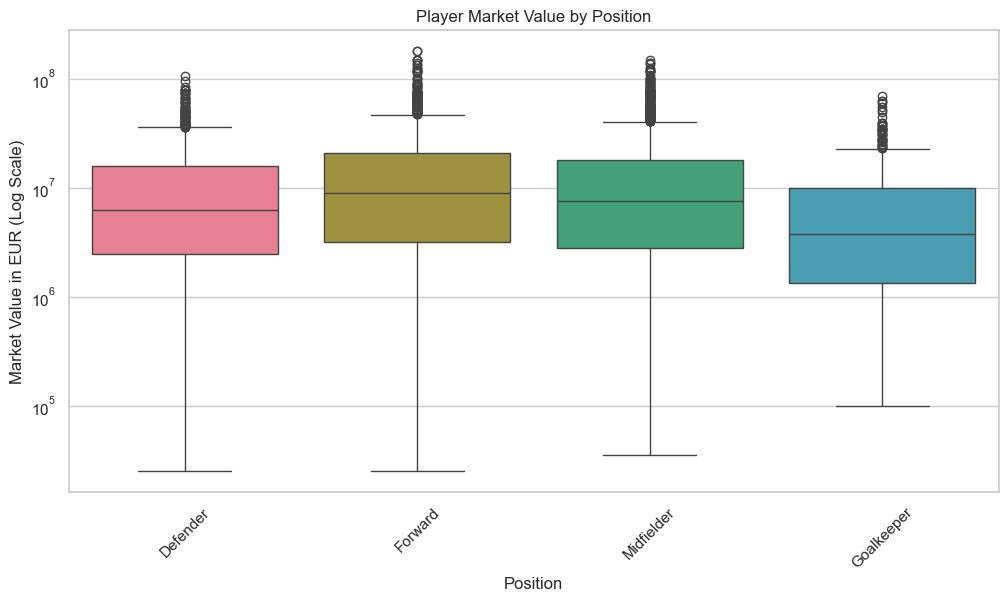

In [30]:
# 2. Player Market Value by Position
plt.figure(figsize=(12, 6))
sns.boxplot(x='Position', y='market_value_in_eur_x', data=final_df, palette=palette, hue = 'Position', legend = False)
plt.xlabel('Position')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Player Market Value by Position')
plt.xticks(rotation=45)
plt.show()

In [31]:
# 3. Impact of Birth Country on Median Market Value for 2023 Season by Position (Map Plot using Plotly)

# Filter data for 2023 season
final_df_2023 = final_df[(final_df['Season'] == 2023)]

# Standardize country names to match Plotly's expectations
final_df_2023['country_of_birth'] = final_df_2023['country_of_birth'].replace({
    'England': 'United Kingdom',
    'Scotland': 'United Kingdom',
    'Wales': 'United Kingdom'
})


C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\4085003044.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_2023['country_of_birth'] = final_df_2023['country_of_birth'].replace({


In [32]:
# Forward Players
final_df_forward = final_df_2023[final_df_2023['Position'] == 'Forward']
country_median_values_forward = final_df_forward.groupby('country_of_birth')['market_value_in_eur_x'].median().reset_index()
fig = px.choropleth(country_median_values_forward,
                    locations='country_of_birth',
                    locationmode='country names',
                    color='market_value_in_eur_x',
                    hover_name='country_of_birth',
                    color_continuous_scale='OrRd',
                    title='Impact of Birth Country on Median Market Value for 2023 Season (Forwards)')
fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()


In [33]:
country_median_values_forward.sort_values('market_value_in_eur_x',ascending=False).reset_index(drop=True).head(10)

country_of_birth  market_value_in_eur_x
0        Argentina             90000000.0
1          Uruguay             70000000.0
2            Egypt             55000000.0
3       The Gambia             35000000.0
4          Jamaica             35000000.0
5      Netherlands             33250000.0
6           Brazil             32750000.0
7          Ireland             28750000.0
8    Guinea-Bissau             25000000.0
9           Sweden             22000000.0

In [34]:
# Midfielders
final_df_midfielder = final_df_2023[final_df_2023['Position'] == 'Midfielder']
country_median_values_midfielder = final_df_midfielder.groupby('country_of_birth')['market_value_in_eur_x'].median().reset_index()
fig = px.choropleth(country_median_values_midfielder,
                    locations='country_of_birth',
                    locationmode='country names',
                    color='market_value_in_eur_x',
                    hover_name='country_of_birth',
                    color_continuous_scale='OrRd',
                    title='Impact of Birth Country on Median Market Value for 2023 Season (Midfielders)')
fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()

In [35]:
country_median_values_midfielder.sort_values('market_value_in_eur_x',ascending=False).reset_index(drop=True).head(10)

country_of_birth  market_value_in_eur_x
0          Ecuador             77500000.0
1          Hungary             75000000.0
2           Sweden             55000000.0
3         Portugal             50000000.0
4          Jamaica             38500000.0
5           Mexico             35000000.0
6            Ghana             34500000.0
7    Cote d'Ivoire             30000000.0
8            Egypt             29250000.0
9            Japan             29000000.0

In [36]:
# Defenders
final_df_defender = final_df_2023[final_df_2023['Position'] == 'Defender']
country_median_values_defender = final_df_defender.groupby('country_of_birth')['market_value_in_eur_x'].median().reset_index()
fig = px.choropleth(country_median_values_defender,
                    locations='country_of_birth',
                    locationmode='country names',
                    color='market_value_in_eur_x',
                    hover_name='country_of_birth',
                    color_continuous_scale='OrRd',
                    title='Impact of Birth Country on Median Market Value for 2023 Season (Defenders)')
fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()

In [37]:
country_median_values_defender.sort_values('market_value_in_eur_x',ascending=False).reset_index(drop=True).head(10)

country_of_birth  market_value_in_eur_x
0          Croatia             75000000.0
1          Ukraine             38000000.0
2    Cote d'Ivoire             38000000.0
3          Morocco             35000000.0
4      Netherlands             32500000.0
5           Poland             30000000.0
6          Ecuador             30000000.0
7            Spain             27500000.0
8      Switzerland             27500000.0
9         Portugal             25000000.0

In [38]:

# Goalkeepers
final_df_goalkeeper = final_df_2023[final_df_2023['Position'] == 'Goalkeeper']
country_median_values_goalkeeper = final_df_goalkeeper.groupby('country_of_birth')['market_value_in_eur_x'].median().reset_index()
fig = px.choropleth(country_median_values_goalkeeper,
                    locations='country_of_birth',
                    locationmode='country names',
                    color='market_value_in_eur_x',
                    hover_name='country_of_birth',
                    color_continuous_scale='OrRd',
                    title='Impact of Birth Country on Median Market Value for 2023 Season (Goalkeepers)')
fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()


In [39]:
country_median_values_goalkeeper.sort_values('market_value_in_eur_x',ascending=False).reset_index(drop=True).head(10)

country_of_birth  market_value_in_eur_x
0               Cameroon             35000000.0
1                  Italy             35000000.0
2                  Spain             28750000.0
3              Argentina             28000000.0
4  Yugoslavia (Republic)             17500000.0
5            Netherlands             15000000.0
6               Portugal             14000000.0
7                Ireland             11250000.0
8         United Kingdom             11000000.0
9                 France             10000000.0

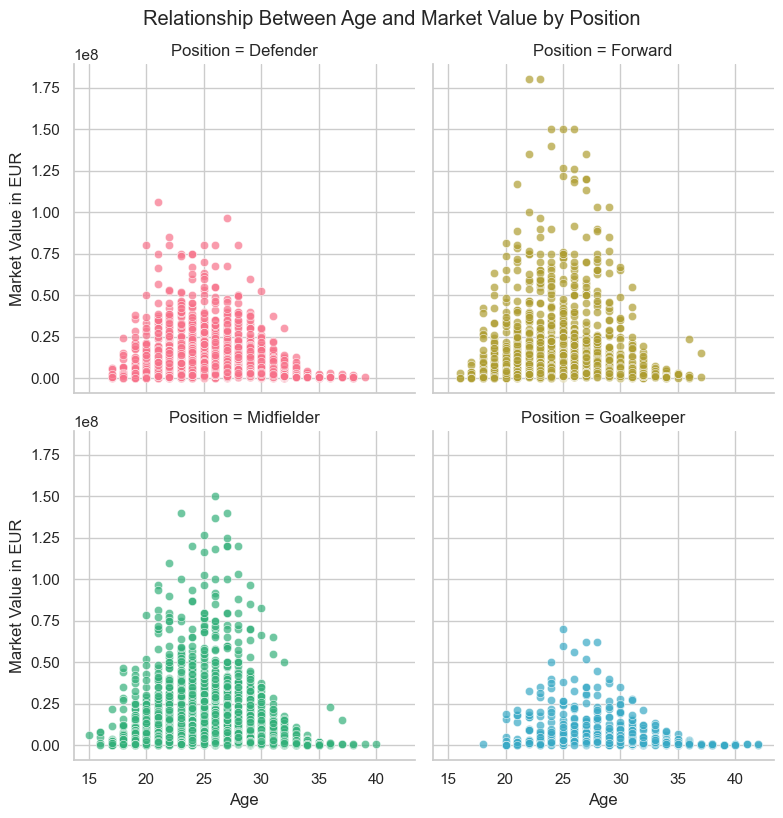

In [40]:
# 4. Relationship Between Appearances and Market Value (All positions) using FacetGrid

g = sns.FacetGrid(final_df, col='Position', col_wrap=2, height=4, palette=palette, hue = 'Position')
g.map(sns.scatterplot, 'age', 'market_value_in_eur_x', alpha=0.7)
g.set_axis_labels('Age', 'Market Value in EUR')
g.fig.suptitle('Relationship Between Age and Market Value by Position', y=1.02)
# plt.yscale('log')
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\1486505617.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\1486505617.py:12: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



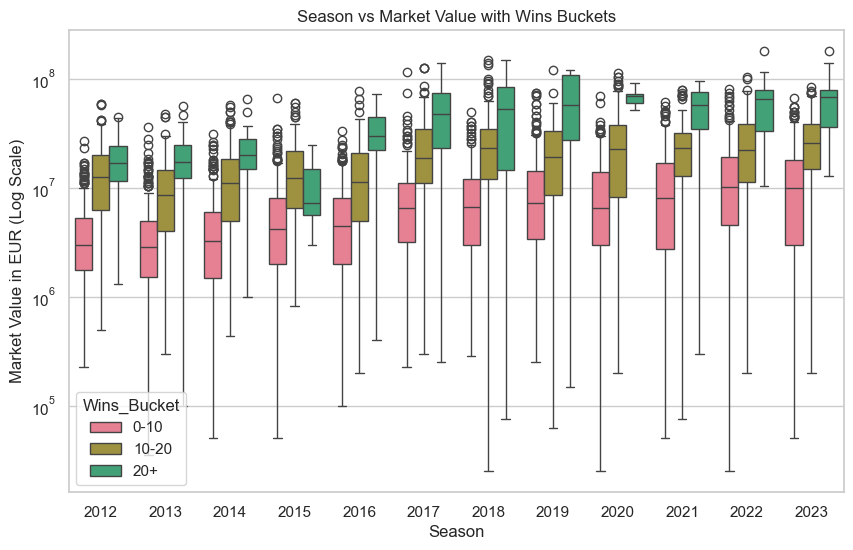

In [41]:
# 5. Season vs Market Value with Wins Buckets (All Positions)
max_wins = final_df['Wins'].max()
max_wins = max_wins + 1 if max_wins <= 20 else max_wins
if max_wins <= 20:
    bins = [0, 10, max_wins]
    labels = ['0-10', '10+']
else:
    bins = [0, 10, 20, max_wins]
    labels = ['0-10', '10-20', '20+']
final_df['Wins_Bucket'] = pd.cut(final_df['Wins'], bins=bins, labels=labels)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='market_value_in_eur_x', hue='Wins_Bucket', data=final_df, palette=palette)
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Wins Buckets')
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\2290439139.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\2290439139.py:4: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



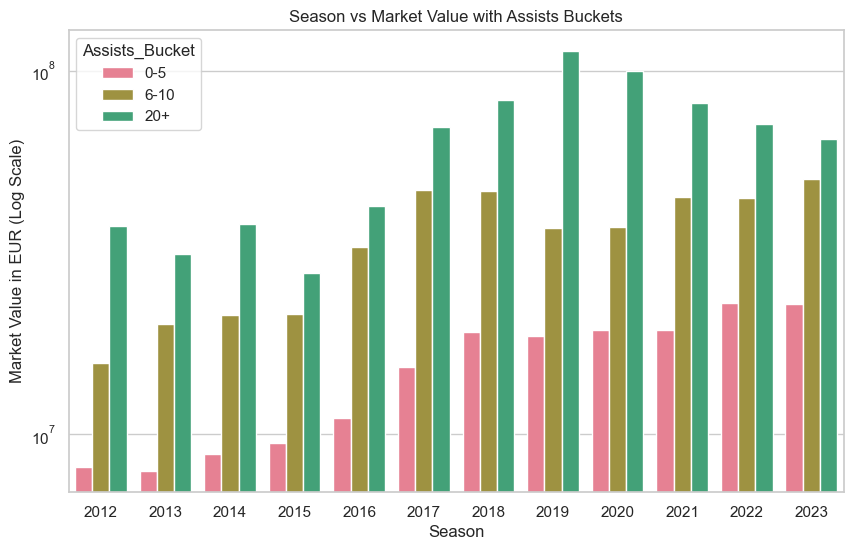

In [42]:
# Create Assists_Bucket column
final_df['Assists_Bucket'] = pd.cut(final_df['Assists'], bins=[0, 5, 10, final_df['Assists'].max()], labels=['0-5', '6-10','20+'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Season', y='market_value_in_eur_x', hue='Assists_Bucket', data=final_df, palette=palette, dodge=True, errorbar=None, edgecolor=None)
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Assists Buckets')
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3586677074.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3586677074.py:6: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



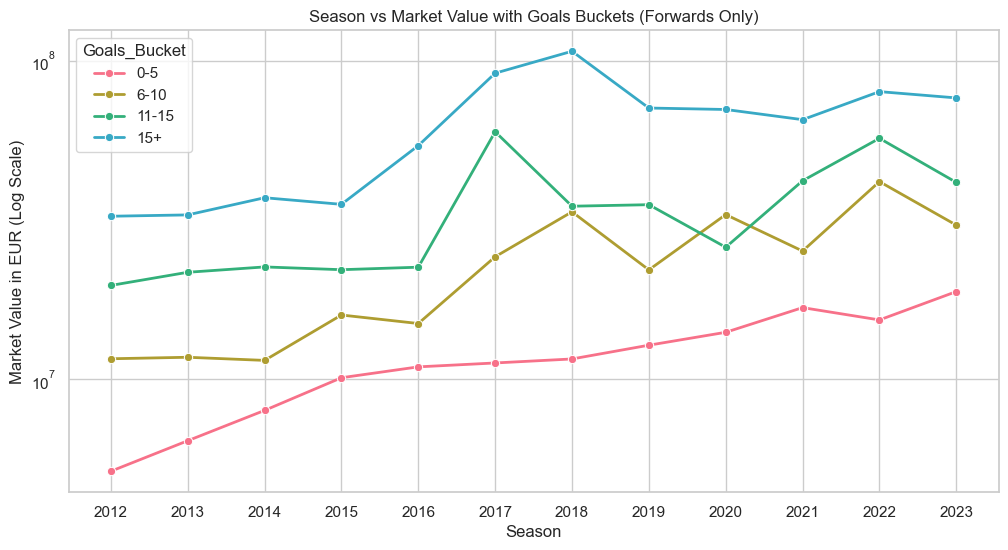

In [43]:
# 6. Season vs Market Value with Average Goals Buckets (Forwards Only)

final_df['Goals_Bucket'] = pd.cut(final_df['Goals'], bins=[0, 5, 10, 15, final_df['Goals'].max()], labels=['0-5', '6-10', '11-15', '15+'])
df_forwards = final_df[(final_df['Position'] == 'Forward')]
plt.figure(figsize=(12, 6))
sns.lineplot(x='Season', y='market_value_in_eur_x', hue='Goals_Bucket', data=df_forwards, palette=palette, marker='o', linewidth=2, errorbar=None)
plt.xticks(final_df['Season'].unique())
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Goals Buckets (Forwards Only)')
# plt.xlim(2011,2024)
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\1290460101.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\1290460101.py:6: UserWarning:

The palette list has more values (5) than needed (2), which may not be intended.



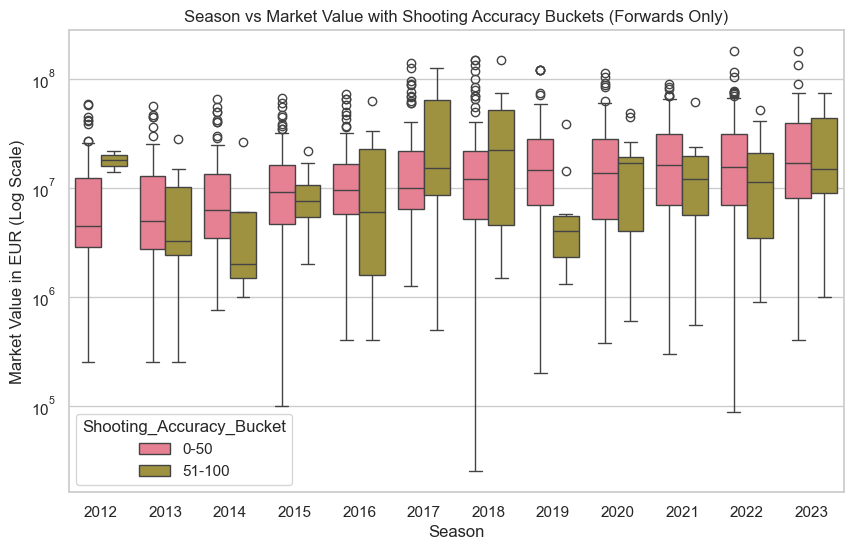

In [44]:
# 7. Season vs Market Value with Shooting Accuracy Buckets (Forwards Only)

final_df['Shooting_Accuracy_Bucket'] = pd.cut(final_df['Shooting accuracy %'], bins=[0, 0.50, 1.00], labels=['0-50',  '51-100'])
df_forwards = final_df[final_df['Position'] == 'Forward']
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='market_value_in_eur_x', hue='Shooting_Accuracy_Bucket', data=df_forwards, palette=palette)
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Shooting Accuracy Buckets (Forwards Only)')
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3101171156.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3101171156.py:6: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



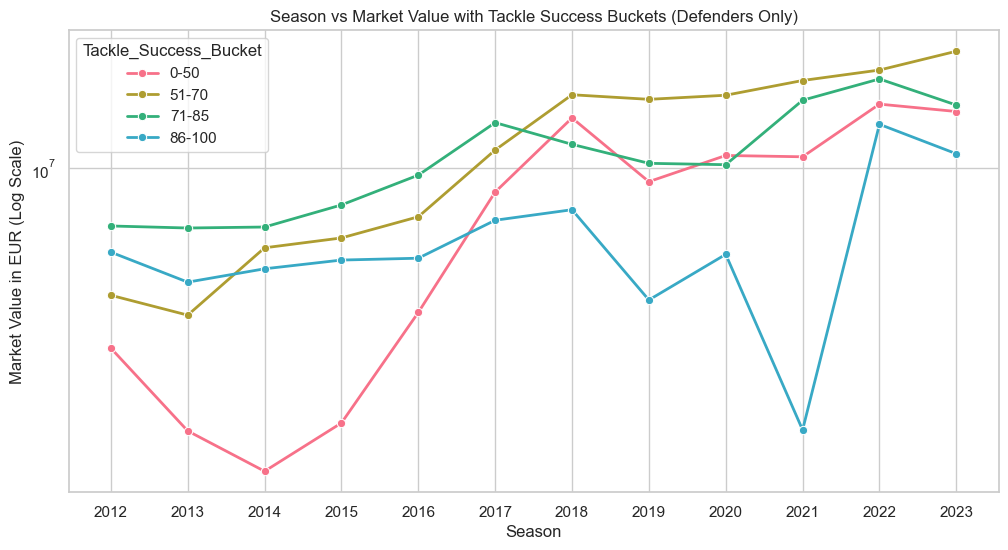

In [45]:
# 8. Season vs Market Value with Tackle Success Buckets (Defenders Only)

final_df['Tackle_Success_Bucket'] = pd.cut(final_df['Tackle success %'], bins=[0, 0.50, 0.70, 0.85, 1.00], labels=['0-50', '51-70', '71-85', '86-100'])
df_defenders = final_df[final_df['Position'] == 'Defender']
plt.figure(figsize=(12, 6))
sns.lineplot(x='Season', y='market_value_in_eur_x', hue='Tackle_Success_Bucket', data=df_defenders, palette=palette, marker='o', linewidth=2, errorbar=None)
plt.xticks(final_df['Season'].unique(), final_df['Season'].unique().astype(int))
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Tackle Success Buckets (Defenders Only)')
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\2284436467.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\2284436467.py:5: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



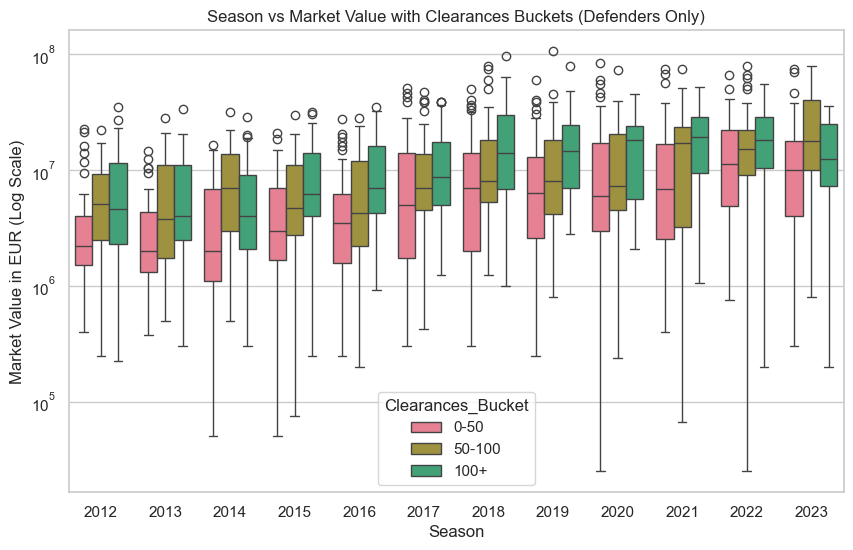

In [46]:
# 9. Season vs Market Value with Clearances Buckets (Defenders Only)

final_df['Clearances_Bucket'] = pd.cut(final_df['Clearances'], bins=[0, 50, 100, final_df['Clearances'].max()], labels=['0-50', '50-100', '100+'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='market_value_in_eur_x', hue='Clearances_Bucket', data=final_df[final_df['Position'] == 'Defender'], palette=palette)
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Clearances Buckets (Defenders Only)')
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3232351634.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\3232351634.py:7: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



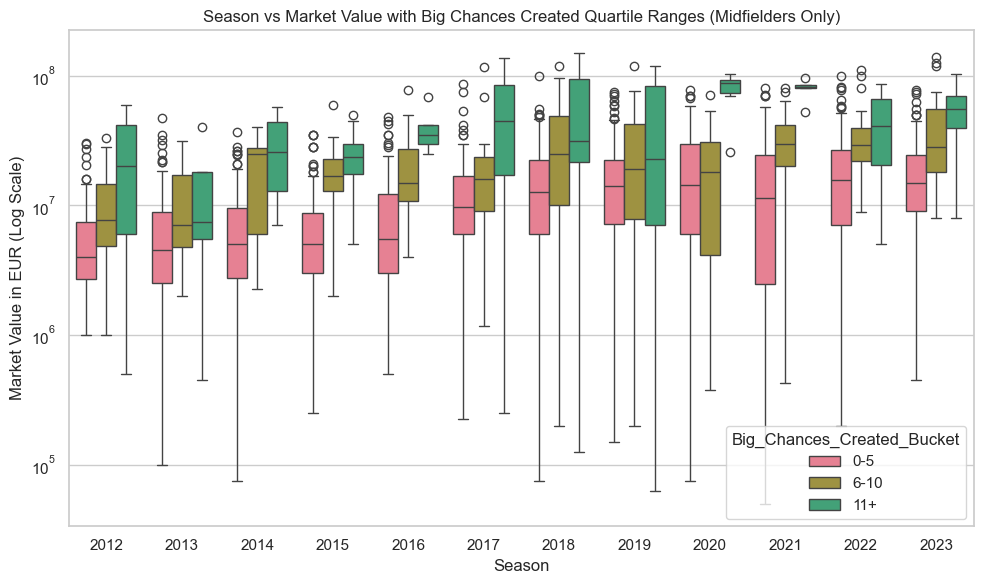

In [47]:
# 10. Season vs Market Value with Big Chances Created Buckets (Midfielders Only)
final_df['Big_Chances_Created_Bucket'] = pd.cut(final_df['Big Chances Created'], 
    bins=[0, 5, 10, 50],
    labels=['0-5', '6-10', '11+'])
df_midfielders = final_df[final_df['Position'] == 'Midfielder']
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='market_value_in_eur_x', hue='Big_Chances_Created_Bucket', data=df_midfielders, palette=palette)
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Big Chances Created Quartile Ranges (Midfielders Only)')
plt.tight_layout()
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\275905107.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ckuck\AppData\Local\Temp\ipykernel_10856\275905107.py:7: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



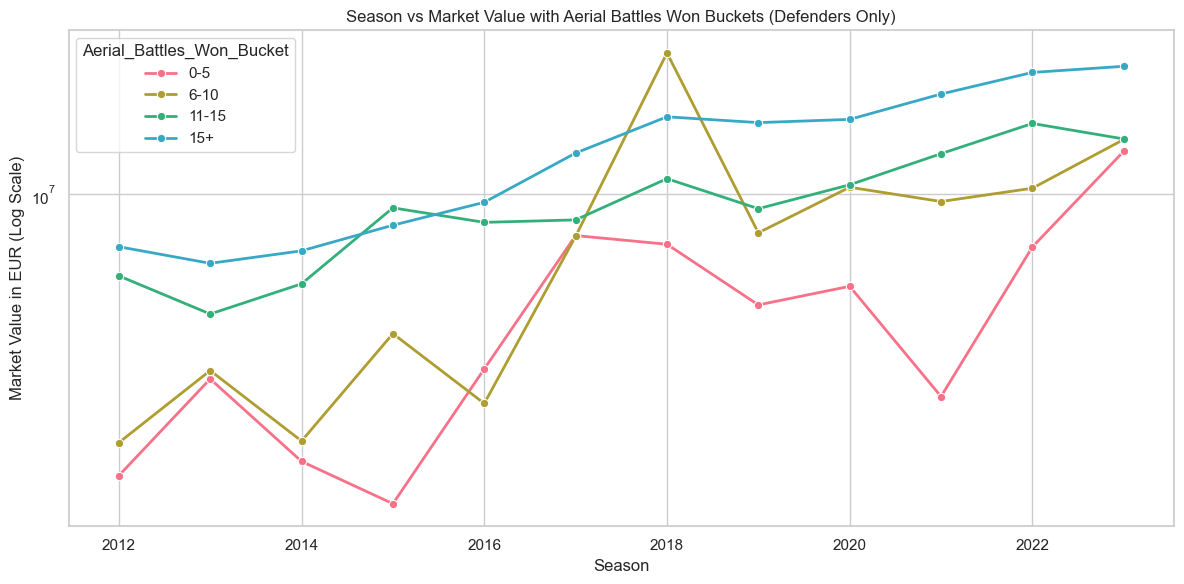

In [48]:
# 11. Season vs Market Value with Aerial Battles Won Buckets (Defenders Only)

final_df['Aerial_Battles_Won_Bucket'] = pd.cut(final_df['Aerial battles won'], bins=[0, 5, 10, 15, final_df['Aerial battles won'].max()],
                                               labels=['0-5', '6-10', '11-15', '15+'])
df_defenders = final_df[final_df['Position'] == 'Defender']
plt.figure(figsize=(12, 6))
sns.lineplot(x='Season', y='market_value_in_eur_x', hue='Aerial_Battles_Won_Bucket', data=df_defenders, palette=palette, marker='o', linewidth=2, errorbar=None)
plt.xlabel('Season')
plt.yscale('log')
plt.ylabel('Market Value in EUR (Log Scale)')
plt.title('Season vs Market Value with Aerial Battles Won Buckets (Defenders Only)')
plt.tight_layout()
plt.show()

## Models

In [49]:
# Feature selection
features = ['country_of_birth','city_of_birth','country_of_citizenship',
'sub_position','foot','Position','player_club_id','Season','Appearances','Wins',
'Losses','Last man tackles','Freekicks scored','Yellow cards','Fouls',
'Shots on target','Sweeper clearances','Assists','Tackle success %','Duels won',
'Goals with left foot','Accurate long balls','Shots','Penalties Saved','Crosses',
'Goals with right foot','Shooting accuracy %','Passes','Catches','Passes per match',
'Headed Clearance','Throw outs','Tackles','Big Chances Created','Hit woodwork',
'High Claims','Goals per match','Offsides','Goal Kicks','Big chances missed',
'Blocked shots','Penalties scored','Clean sheets','Own goals','Successful 50/50s',
'Recoveries','Clearances off line','Goals','Interceptions','Aerial battles won',
'Cross accuracy %','Punches','Clearances','Errors leading to goal',
'Duels lost','Aerial battles lost','Goals Conceded','Through balls','Saves',
'Headed goals','Red cards','height_in_cm','age']

print(len(features))


63


In [50]:
X = final_df[features]
y = final_df['market_value_in_eur_x']  # Target is now the market value

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical column indices
categorical_features = [0,1,2,3,4,5,6] 

In [51]:
# Preprocessor for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1000)),  # Fill missing values with the mean for numeric columns
    ('scaler', StandardScaler())
])

# Preprocessor for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Fill missing values with the most frequent value for categorical columns
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer to apply the transformations to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(range(7, 63))),  # Numeric columns
        ('cat', categorical_transformer, categorical_features)  # Categorical columns
    ]
)


Test Mean Squared Error: 238622281714768.03
Test Mean Absolute Error: 6700291.590800942
Test R^2 Score: 0.2729843342174729
Training Mean Squared Error: 82781506557919.38
Training Mean Absolute Error: 4611694.398853086
Training R^2 Score: 0.7357090209863173
Top 10 Numerical Features by Importance:
                  Feature  Coefficient  Importance
19    Shooting accuracy %    82.446134   82.446134
34       Penalties scored   -33.119873   33.119873
4        Last man tackles    27.668283   27.668283
16        Penalties Saved   -24.288757   24.288757
35           Clean sheets    21.306779   21.306779
18  Goals with right foot   -13.824935   13.824935
13   Goals with left foot   -13.670955   13.670955
5        Freekicks scored   -13.456677   13.456677
39    Clearances off line   -11.370270   11.370270
11       Tackle success %     9.106428    9.106428


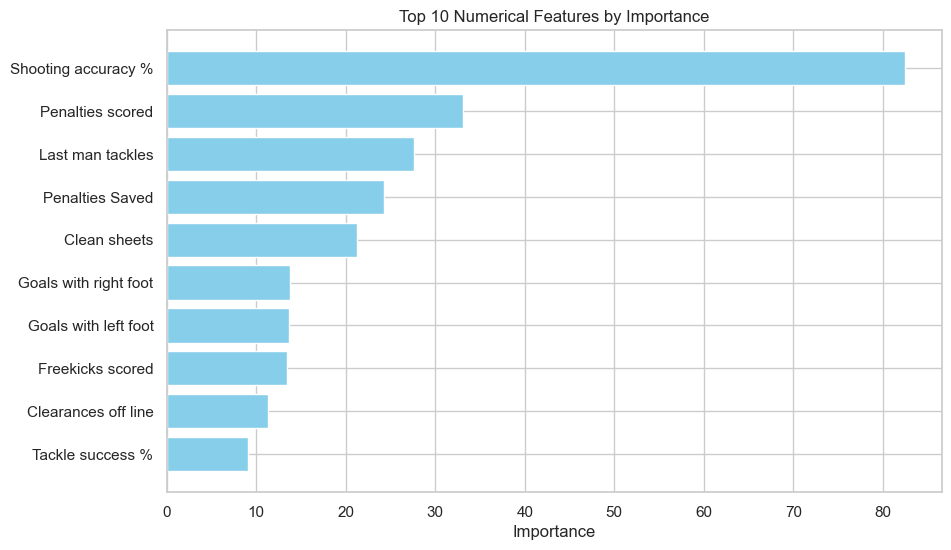

In [52]:


# Preprocessor for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1000)),  # Fill missing values with the mean for numeric columns
    ('scaler', StandardScaler())
])

# Preprocessor for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Fill missing values with the most frequent value for categorical columns
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer to apply the transformations to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(range(7, 63))),  # Numeric columns
        ('cat', categorical_transformer, categorical_features)  # Categorical columns
    ]
)

# Define the pipeline with Linear Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model using log-transformed target
model_pipeline.fit(X_train, np.log(y_train))

# Evaluate the model on the test set using log-transformed prediction
y_pred_log = model_pipeline.predict(X_test)
y_pred = np.exp(y_pred_log)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Test Mean Squared Error:", mse_test)
print("Test Mean Absolute Error:", mae_test)
print("Test R^2 Score:", r2_test)


# Evaluate on the training set using log-transformed prediction
y_train_pred_log = model_pipeline.predict(X_train)
y_train_pred = np.exp(y_train_pred_log)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("Training Mean Squared Error:", mse_train)
print("Training Mean Absolute Error:", mae_train)
print("Training R^2 Score:", r2_train)


# Get feature importance from linear regression coefficients
regressor = model_pipeline.named_steps['regressor']
coefficients = regressor.coef_.flatten() if len(regressor.coef_.shape) > 1 else regressor.coef_

# Assuming X_train is a DataFrame so we can extract feature names
if isinstance(X_train, pd.DataFrame):
    numeric_feature_names = [X_train.columns[i] for i in model_pipeline.named_steps['preprocessor'].transformers_[0][2]]
    feature_names = numeric_feature_names
else:
    feature_names = [f'feature_{i}' for i in range(len(coefficients))]

# Ensure coefficients and feature names have the same length
min_length = min(len(coefficients), len(feature_names))
coefficients = coefficients[:min_length]
feature_names = feature_names[:min_length]

# Create a DataFrame of features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Take the absolute value of coefficients and sort them in descending order to get top 10 numerical features
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
top_10_numerical_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)

print("Top 10 Numerical Features by Importance:")
print(top_10_numerical_features)

# Plot a bar graph for the top 10 numerical features
plt.figure(figsize=(10, 6))
plt.barh(top_10_numerical_features['Feature'], top_10_numerical_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Numerical Features by Importance')
plt.gca().invert_yaxis()
plt.show()

In [53]:


# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 150, step=10),
        'max_depth': trial.suggest_int('max_depth', 15, 50, step=5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }

    # Define the pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, **params))
    ])

    # Fit the pipeline using log-transformed target
    model_pipeline.fit(X_train, np.log(y_train))

    # Evaluate the pipeline
    y_pred_log = model_pipeline.predict(X_test)
    y_pred = np.exp(y_pred_log)
    mse = mean_squared_error(y_test, y_pred)

    # Return the negative MSE (since Optuna maximizes the objective by default)
    return -mse

# Create the study
study = optuna.create_study(direction='maximize')  # Maximize R^2
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train and evaluate the best model
best_params = study.best_params
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, **best_params))
])

# Train the best model using log-transformed target
best_model_pipeline.fit(X_train, np.log(y_train))

[I 2025-01-04 02:22:19,685] A new study created in memory with name: no-name-24df3c67-111e-4fef-aa36-1d30cf90b2e1
[I 2025-01-04 02:22:29,466] Trial 0 finished with value: -106468578705290.84 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.6548885255041165}. Best is trial 0 with value: -106468578705290.84.
[I 2025-01-04 02:22:35,634] Trial 1 finished with value: -106506774256238.67 and parameters: {'n_estimators': 30, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.6773524903018949}. Best is trial 0 with value: -106468578705290.84.
[I 2025-01-04 02:22:49,141] Trial 2 finished with value: -103753600236779.47 and parameters: {'n_estimators': 50, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.8993003267825259}. Best is trial 2 with value: -103753600236779.47.
[I 2025-01-04 02:23:48,656] Trial 3 finished with value: -96637815684689.39 and parameters: {'

Best Hyperparameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.8202039744365386}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1000,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [7, 8, 9, 10, 11, 12, 13, 14,
                                                   15, 16, 17, 18, 19, 20, 21,
                                                   22, 23, 24, 25, 26, 27, 28,
                                                   29, 30, 31, 32, 33, 34, 35,
                                                   36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('regressor',
                 RandomForestRegressor(max_depth=45,
                                       max_features=0.8202039744365386,
                                       min_samples_split=3, n_estimators=150,
                                       random_state=42))])

Test Mean Squared Error: 95360010559220.88
Test Mean Absolute Error: 5173808.373183239
Test R^2 Score: 0.7094645937188264


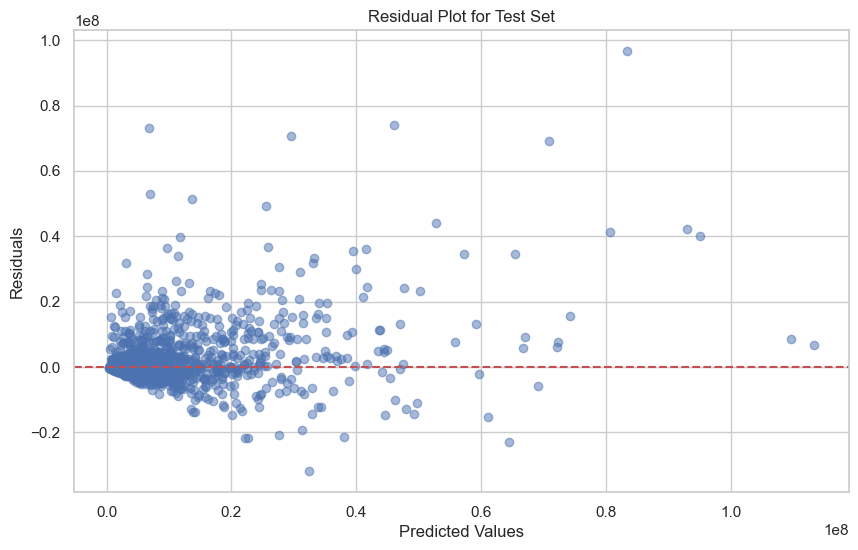

Training Mean Squared Error: 21557872715779.31
Training Mean Absolute Error: 2164419.805957106
Training R^2 Score: 0.9311736217132109


In [54]:
# Evaluate the best model on the test set
y_pred_log = best_model_pipeline.predict(X_test)
y_pred = np.exp(y_pred_log)
print("Test Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Test Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Test R^2 Score:", r2_score(y_test, y_pred))

# Residual plot for test set
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Test Set')
plt.show()

# Evaluate on the training set
y_train_pred_log = best_model_pipeline.predict(X_train)
y_train_pred = np.exp(y_train_pred_log)
print("Training Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("Training Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Training R^2 Score:", r2_score(y_train, y_train_pred))

In [55]:
# Define the pipeline with XGBoost
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define the objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
    }
    
    # Update pipeline with hyperparameters
    model_pipeline.set_params(regressor__n_estimators=params['n_estimators'],
                              regressor__max_depth=params['max_depth'],
                              regressor__learning_rate=params['learning_rate'],
                              regressor__subsample=params['subsample'],
                              regressor__colsample_bytree=params['colsample_bytree'],
                              regressor__min_child_weight=params['min_child_weight'],
                              regressor__gamma=params['gamma'],
                              regressor__reg_alpha=params['reg_alpha'],
                              regressor__reg_lambda=params['reg_lambda'])
    
    # Train and evaluate using log-transformed target
    model_pipeline.fit(X_train, np.log(y_train))
    y_pred_log = model_pipeline.predict(X_test)
    y_pred = np.exp(y_pred_log)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best model
print("Best Parameters:", study.best_params)

# Train and evaluate the best model
best_params = study.best_params
xgb_best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, **best_params))
])

# Train the best model using log-transformed target
xgb_best_model_pipeline.fit(X_train, np.log(y_train))


[I 2025-01-04 02:52:03,407] A new study created in memory with name: no-name-afafe16a-b34b-4386-a0eb-45c18af99d91
[I 2025-01-04 02:52:03,745] Trial 0 finished with value: 0.7665371681947887 and parameters: {'n_estimators': 466, 'max_depth': 8, 'learning_rate': 0.15697420169502116, 'subsample': 0.9729595050673062, 'colsample_bytree': 0.7766052656673901, 'min_child_weight': 1, 'gamma': 0.36227516270693766, 'reg_alpha': 0.3012279198382619, 'reg_lambda': 1.7545732300613905}. Best is trial 0 with value: 0.7665371681947887.
[I 2025-01-04 02:52:04,063] Trial 1 finished with value: 0.7865936008275292 and parameters: {'n_estimators': 341, 'max_depth': 5, 'learning_rate': 0.12927881132031777, 'subsample': 0.9482597009864737, 'colsample_bytree': 0.5568285976066469, 'min_child_weight': 2, 'gamma': 0.16813677379187691, 'reg_alpha': 0.20763154358403146, 'reg_lambda': 4.847992589213479}. Best is trial 1 with value: 0.7865936008275292.
[I 2025-01-04 02:52:04,479] Trial 2 finished with value: 0.7691461

Best Parameters: {'n_estimators': 366, 'max_depth': 5, 'learning_rate': 0.13109119750730552, 'subsample': 0.8186095531311235, 'colsample_bytree': 0.9982064740628472, 'min_child_weight': 5, 'gamma': 0.2509315129796699, 'reg_alpha': 0.24885571948897997, 'reg_lambda': 1.9208464165985708}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1000,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [7, 8, 9, 10, 11, 12, 13, 14,
                                                   15, 16, 17, 18, 19, 20, 21,
                                                   22, 23, 24, 25, 26, 27, 28,
                                                   29, 30, 31, 32, 33, 34, 35,
                                                   36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strate...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.13109119750730552, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=366, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

Test Mean Squared Error: 54845697651038.51
Test Mean Absolute Error: 4237161.192992561
Test R^2 Score: 0.8329004269570304


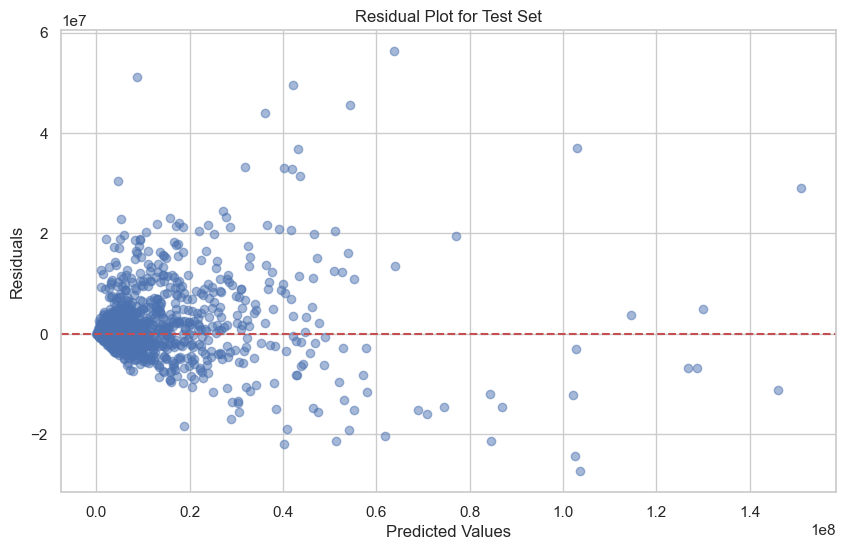

Training Mean Squared Error: 22944619388977.53
Training Mean Absolute Error: 2545697.951880334
Training R^2 Score: 0.9267462483644655


In [56]:
# Evaluate the best model on the test set
y_pred_log = xgb_best_model_pipeline.predict(X_test)
y_pred = np.exp(y_pred_log)
print("Test Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Test Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Test R^2 Score:", r2_score(y_test, y_pred))

# Residual plot for test set
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Test Set')
plt.show()

# Evaluate on the training set
y_train_pred_log = xgb_best_model_pipeline.predict(X_train)
y_train_pred = np.exp(y_train_pred_log)
print("Training Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("Training Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Training R^2 Score:", r2_score(y_train, y_train_pred))

In [57]:
# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

X_train_preprocessed_dense = X_train_preprocessed.toarray()
X_test_preprocessed_dense = X_test_preprocessed.toarray()

nn_model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_preprocessed_dense.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.0003), loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = nn_model.fit(
    X_train_preprocessed_dense, np.log(y_train),
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model on the test set
y_pred = nn_model.predict(X_test_preprocessed_dense).flatten()



Epoch 1/1000
122/122 [==============================] - 1s 5ms/step - loss: 248.5552 - mae: 15.4155 - val_loss: 232.2162 - val_mae: 14.9576 - lr: 3.0000e-04
Epoch 2/1000
122/122 [==============================] - 0s 3ms/step - loss: 227.2462 - mae: 14.7705 - val_loss: 211.0058 - val_mae: 14.2549 - lr: 3.0000e-04
Epoch 3/1000
122/122 [==============================] - 0s 3ms/step - loss: 199.8174 - mae: 13.8117 - val_loss: 177.8199 - val_mae: 13.0436 - lr: 3.0000e-04
Epoch 4/1000
122/122 [==============================] - 0s 3ms/step - loss: 163.9714 - mae: 12.4292 - val_loss: 139.1176 - val_mae: 11.4751 - lr: 3.0000e-04
Epoch 5/1000
122/122 [==============================] - 0s 3ms/step - loss: 121.8846 - mae: 10.5715 - val_loss: 91.2550 - val_mae: 9.1434 - lr: 3.0000e-04
Epoch 6/1000
122/122 [==============================] - 0s 3ms/step - loss: 81.1501 - mae: 8.3856 - val_loss: 57.8094 - val_mae: 7.1050 - lr: 3.0000e-04
Epoch 7/1000
122/122 [==============================] - 0s 3ms/s

Test Mean Squared Error: 72423273481038.31
Test Mean Absolute Error: 4655185.523867059
Test R^2 Score: 0.7793464465698784
152/152 [==============================] - 0s 1ms/step
Training Mean Squared Error: 49619139513755.83
Training Mean Absolute Error: 3464496.997077892
Training R^2 Score: 0.8415842921301306


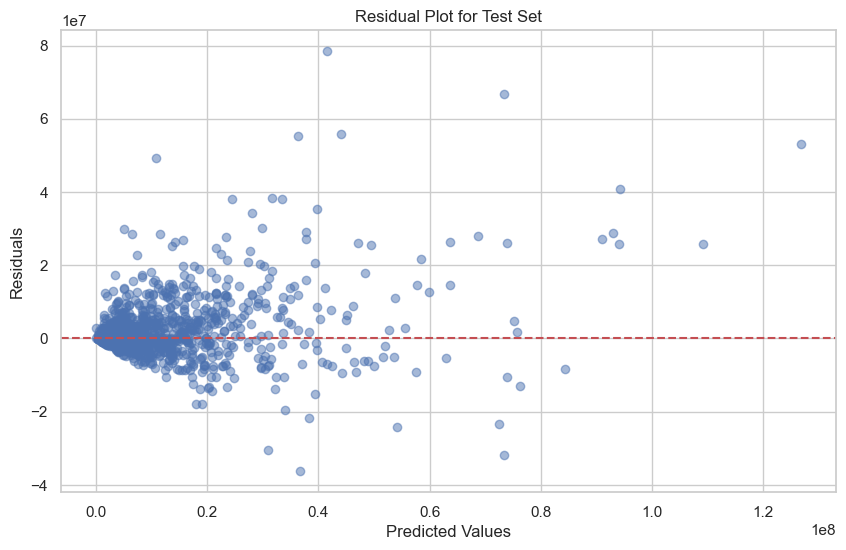

In [68]:
# Calculate metrics
mse = mean_squared_error(y_test, np.exp(y_pred))
mae = mean_absolute_error(y_test, np.exp(y_pred))
r2 = r2_score(y_test, np.exp(y_pred))

print("Test Mean Squared Error:", mse)
print("Test Mean Absolute Error:", mae)
print("Test R^2 Score:", r2)

# Evaluate on the training set (unbalanced)
y_train_pred = nn_model.predict(X_train_preprocessed_dense).flatten()
mse_train = mean_squared_error(y_train, np.exp(y_train_pred))
mae_train = mean_absolute_error(y_train, np.exp(y_train_pred))
r2_train = r2_score(y_train, np.exp(y_train_pred))

print("Training Mean Squared Error:", mse_train)
print("Training Mean Absolute Error:", mae_train)
print("Training R^2 Score:", r2_train)

# Residual plot for test set
residuals = y_test - np.exp(y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(np.exp(y_pred), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Test Set')
plt.show()

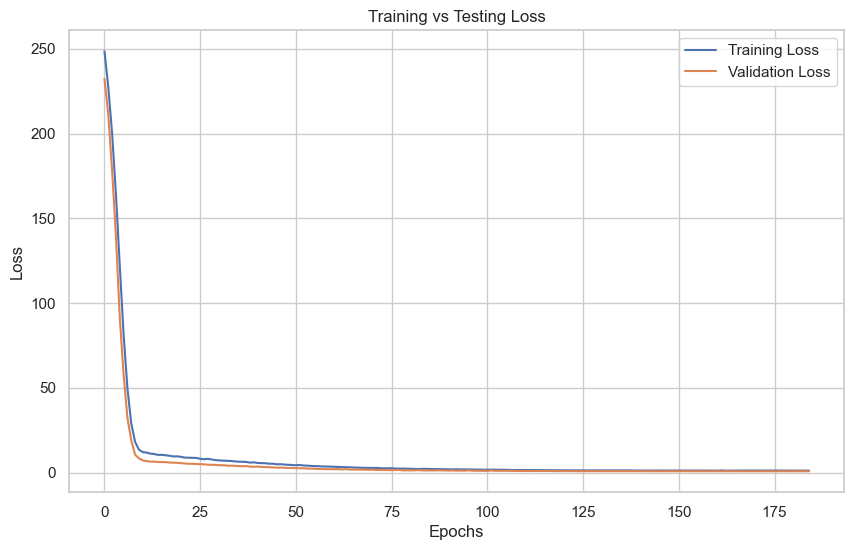

In [62]:
# Plot training vs testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


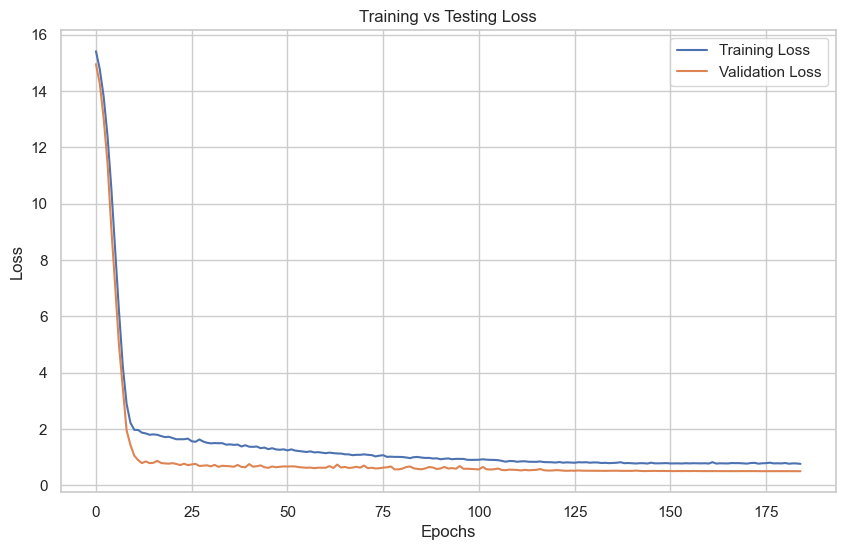

In [63]:
# Plot training vs testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training Loss')
plt.plot(history.history['val_mae'], label='Validation Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
